**mode collapse:** generator stuck in a single mode (peak of the distribution)

**loss value meaning:** not a good correlation between the loss value and the quality of the generated results

**bce loss problems -** flat gradients

we'll use **the wasserstein loss** instead of binary cross entropy.

**earth mover distance:** the effort needed to make both real and generated distributions equal.

In [1]:
# coding an advanced GAN from scratch in python + pytorch
# importing the libraries

import torch, torchvision, os, PIL, pdb # pytorch and torchvision are for datasets and image transforms, os if for file handling, pil is for image processing, and pdb if for debugging
from torch import nn # neural network module
from torch.utils.data import Dataset # dataset class and data loader to create custom datasets and load them in batches
from torch.utils.data import DataLoader
from torchvision import transforms # transforms module from torchvision to apply image preprocessing
from torchvision.utils import make_grid # function to create a grid of images for visualisation
from tqdm.auto import tqdm # progress bar tool for loops
import matplotlib.pyplot as plt # for plotting images and graphs
import numpy as np # for numerical operations
from PIL import Image # image module from pillow for image loading and handling

In [2]:
def show(tensor, num = 25, wandb = 0, name = ''):
  data = tensor.detach().cpu()   # detach tensor from computation graph and move it to cpu
  grid = make_grid(data[:num], nrow = 5).permute(1, 2, 0)   # create a grid of images (5 per row), rearrange axes for plotting

  # optional: log images to wandb if enabled
  if (wandb == 1 and wandbact ==1):
    wandb.log({name: wandb.Image(grid.numpy().clip(0,1))})

  plt.imshow(grid.clip(0, 1))
  plt.show()

#hyperparameters and general parameters
n_epochs = 100000 # number of training iterations
batch_size = 128 # number of images per batch
lr = 1e-4 # learning rate for optimiser
z_dim = 200 # size of the noise vector for generator
device = 'cuda' # GPU for training

cur_step = 0 # current step in training
crit_cycles = 5 # number of critic updates per generator update (used in wgan)
gen_losses = [] # to track generator loss over time
crit_losses = [] # to track critic/discriminator loss over time
show_step = 35 # how often to display generated image
save_step = 35 # how often to display model check points

wandbact = 1 # yes we want to track stats through weights and biases, optional

In [3]:
# optional
!pip install wandb
import wandb
wandb.login(key = 'YOUR KEY HERE' )

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: burciadilammermoore (burciadilammermoore-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
%%capture
experiment_name = wandb.util.generate_id() # generate a unique id for the experiment

myrun = wandb.init( # initialise a wandb run
    project = 'wgan', # name of the project: wassersteing gan
    group = experiment_name, # group name used to group related runs
    config = { # configuration dictionary
        'optimizer': 'sgd', # use stochastic gradient descent
        'model': 'wgan gp', # model type is wasserstein gan with gradient penalty
        'epoch': 1000, # traning epochs
        'batch_size': 128 # samples per batch
    }
)

config = wandb.config # store wand config for early access

In [5]:
print(experiment_name)

bkklqtmy


In [6]:
# generator model

class Generator(nn.Module):
  def __init__(self, z_dim = 64, d_dim = 16):
    super(Generator, self).__init__()
    self.z_dim = z_dim

    self.gen = nn.Sequential(
        ## ConvTranspose2d: in_channels, out_channels, kernel_size, stride = 1, padding = 0
        ## calculating new width and height: ((n-1) * stride) - (2 * padding) + ks
        ## n: width or height
        ## ks: kernel size
        nn.ConvTranspose2d (z_dim, d_dim * 32, 4, 1, 0 ), ## we begin with a 1x1 image with z_dim number of channels (200) --> 4x4 (ch: 200 -> 512)
        nn.BatchNorm2d(d_dim * 32), # normalise values
        nn.ReLU(inplace = True), # add non-linearity

        nn.ConvTranspose2d (d_dim * 32, d_dim * 16, 4, 2, 1), ## 8x8 (ch: 512 -> 256)
        nn.BatchNorm2d(d_dim * 16), # normalise values
        nn.ReLU(inplace = True), # add non-linearity

        nn.ConvTranspose2d (d_dim * 16, d_dim * 8, 4, 2, 1), ## 16x16 (ch: 256 -> 128) because ((n-1) * stride) - (2 * padding) + ks = ((8-1) * 2) - (2 * 1) + 4) = 16
        nn.BatchNorm2d(d_dim * 8), # normalise values
        nn.ReLU(inplace = True), # add non-linearity

        nn.ConvTranspose2d (d_dim * 8, d_dim * 4, 4, 2, 1), ## 32x32 (ch: 128 -> 64)
        nn.BatchNorm2d(d_dim * 4), # normalise values
        nn.ReLU(inplace = True), # add non-linearity

        nn.ConvTranspose2d (d_dim * 4, d_dim * 2, 4, 2, 1), ## 64x64 (ch: 64 -> 32)
        nn.BatchNorm2d(d_dim * 2), # normalise values
        nn.ReLU(inplace = True), # add non-linearity

        nn.ConvTranspose2d (d_dim * 2, 3, 4, 2, 1), ## 128x128 (ch: 32 -> 3)
        nn.Tanh() # add non-linearity, produce result in the range from -1 to 1

    )

  def forward(self, noise):
    x = noise.view(len(noise), self.z_dim, 1, 1) # reshape noise to (batch_size, z_dim, 1, 1) ---> 128 x 200 x 1 x 1
    return self.gen(x)


def gen_noise(num, z_dim, device = 'cuda'):
  return torch.randn(num, z_dim, device = device) # set of noise vectors of 128 x 200

In [7]:
# critic model

class Critic (nn.Module):
  def __init__(self, d_dim = 16):
    super(Critic, self).__init__()

    self.crit = nn.Sequential(
        ## Conv2d: in_channels, out_channels, kernel_size, stride = 1, padding = 0
        ## calculating new width and height: ((n + (2 * padding) - ks) // stride) + 1
        nn.Conv2d(3, d_dim, 4, 2, 1), ## (n + (2 * padding) - ks) // stride + 1 = ((128 + (2 * 1) - 4)//2) + 1 = 64x64 (ch: 3 -> 16)
        nn.InstanceNorm2d(d_dim), # normalise values by instance (works well)
        nn.LeakyReLU(0.2), # add non-linearity

        nn.Conv2d(d_dim, d_dim * 2, 4, 2, 1), ## 32x32 (ch: 16 -> 32)
        nn.InstanceNorm2d(d_dim * 2), # normalise values
        nn.LeakyReLU(0.2), # add non-linearity

        nn.Conv2d(d_dim * 2, d_dim * 4, 4, 2, 1), ## 16x16 (ch: 32 -> 64)
        nn.InstanceNorm2d(d_dim * 4), # normalise values
        nn.LeakyReLU(0.2), # add non-linearity

        nn.Conv2d(d_dim * 4, d_dim * 8, 4, 2, 1), ## 8x8 (ch: 64 -> 128)
        nn.InstanceNorm2d(d_dim * 8), # normalise values
        nn.LeakyReLU(0.2), # add non-linearity

        nn.Conv2d(d_dim * 8, d_dim * 16, 4, 2, 1), ## 4x4 (ch: 128 -> 256)
        nn.InstanceNorm2d(d_dim * 16), # normalise values
        nn.LeakyReLU(0.2), # add non-linearity

        nn.Conv2d(d_dim * 16, 1, 4, 1, 0), ## 1x1 (ch: 256 -> 1) # this will tell if the image is real or fake

    )

  def forward(self, image):
    # image: 128 x 3 x 128 x 128
    crit_pred = self.crit(image) # pass image through critic, 128 x 1 x 1 x 1
    return crit_pred.view(len(crit_pred), -1) # reshape output to (batch_size, 1): 128 x 1


In [8]:
# optional way of initialising the parameters
def init_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02) # initialise weights with a normal distribution with 0 mean and 0.02 variance
    torch.nn.init.constant_(m.bias, 0) # set all biases to zero

  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02) # initialise batchnorm weights with a normal distribution
    torch.nn.init.constant_(m.bias, 0) # set all biases to zero

In [9]:
# load dataset
import gdown, zipfile # import libraries for downloading and extracting files

URL = 'https://dl.dropboxusercontent.com/scl/fi/vltmt8hlgdf9mv9kn7d0b/img_align_celeba.zip?rlkey=tacwpkr8d9bjpctdftjg3b00a' # current url of the dataset
path = 'data/celeba' # target directory to save the dataset
download_path = f'{path}/img_align_celeba.zip' # full path for the downloaded zip file

if not os.path.exists(path): # check if the directory exists
  os.makedirs(path, exist_ok = True) # create the directory if it doesn't exist

gdown.download(URL, download_path, quiet = False) # download the dataset using gdown

with zipfile.ZipFile(download_path, 'r') as ziphandler: # open the zip file
  ziphandler.extractall(path) # extract all contents to the target directory


Downloading...
From: https://dl.dropboxusercontent.com/scl/fi/vltmt8hlgdf9mv9kn7d0b/img_align_celeba.zip?rlkey=tacwpkr8d9bjpctdftjg3b00a
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [02:21<00:00, 10.2MB/s]


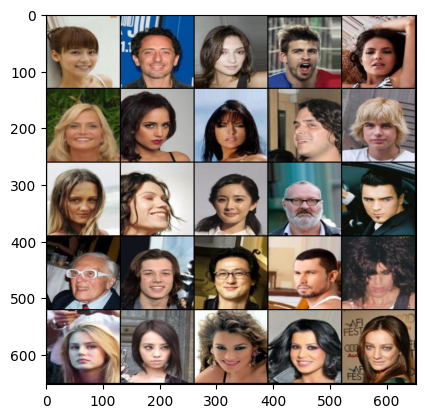

In [10]:
# dataset, dataLoader; declare gen, crit, test dataset

class Dataset(Dataset): # custom dataset class
  def __init__(self, path, size = 128, lim = 10000): # initialise with image path, resize size, and limit
    self.sizes = [size, size] # target size for resizing images
    items, labels = [], []

    for data in os.listdir(path)[:lim]: # loop through limited number of image files
      # path: '.data/celeba/img_align_celeba'
      # data: '114568.jpg'
      item = os.path.join(path, data) # full path to image
      items.append(item) # add image path to list
      labels.append(data) # use filename as label
    self.items = items
    self.labels = labels


  def __len__(self):
    return len(self.items) # return total number of items

  def __getitem__(self, idx):
    data = PIL.Image.open(self.items[idx]).convert('RGB') # open image and convert to rgb
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # resize image to 128x128x3
    data = np.transpose(data, (2, 0, 1)).astype(np.float32, copy=False) # transpose to channel first format: 3x128x128 and convert to float32
    data = torch.from_numpy(data).div(255) # convert to tensor and normalise to [0, 1]
    return data, self.labels[idx] # return preprocessed image and its label

# dataset
data_path = './data/celeba/img_align_celeba' # dataset folder path
ds = Dataset(data_path, size = 128, lim = 10000) # create dataset instance

# dataloader
dataloader = DataLoader(ds, batch_size = batch_size, shuffle = True) # create dataloader with shuffling

# models
gen = Generator(z_dim).to(device) # create generator model and move to device
crit = Critic().to(device) # create critic model and move to device

# optimisers
gen_opt = torch.optim.Adam(gen.parameters(), lr = lr, betas = (0.5, 0.9)) # optimiser for generator
crit_opt = torch.optim.Adam(crit.parameters(), lr = lr, betas = (0.5, 0.9)) # optimiser for critic

# initialisations
## gen = gen.apply(init_weights) # apply initialisation to the generator
## crit = crit.apply(init_weights) # apply initialisation to the critic

# wandb optional
if (wandbact == 1):
  wandb.watch(gen, log_freq = 100) # track generator parameters and gradients every 100 steps
  wandb.watch(crit, log_freq = 100) # track critic parameters and gradients every 100 steps

x, y = next(iter(dataloader)) # fetch one batch from the dataloader
show(x) # display the batch of images

In [11]:
# gradient penalty calculation

def get_gp(real, fake, crit, alpha, gamma = 10):
  mix_images = real * alpha + fake * (1-alpha) # interpolate between real and fake images (shape: 128 x 3 x 128 x 128)
  mix_scores = crit(mix_images) # pass mixed images through critic to get scores (shape: 128 x 1)

  gradient = torch.autograd.grad( # calculate gradient of mix_scores with respect to mix_images
    inputs = mix_images,
    outputs = mix_scores,
    grad_outputs = torch.ones_like(mix_scores), # set gradient output to 1
    create_graph = True, # retain computation graph for higher-order derivatives
    retain_graph = True
  )[0] # extract gradient tensor (shape: 128 x 3 x 128 x 128)

  gradient = gradient.view(len(gradient), -1) # flatten each gradient to a vector (shape: 128 x 49152)
  gradient_norm = gradient.norm(2, dim = 1) # calculate L2 norm of each gradient vector (shape: 128)

  gp = gamma * torch.mean((gradient_norm - 1) ** 2) # compute gradient penalty (should be close to 0 if norm ≈ 1)
  return gp # return scalar gradient penalty

In [13]:
# save and load checkpoints

root_path='./data/' # directory to store checkpoint files

def save_checkpoint(name):
  torch.save({ # save generator's training state
      'epoch': epoch, # current epoch
      'model_state_dict': gen.state_dict(), # generator weights
      'optimiser_state_dict': gen_opt.state_dict() # generator optimiser state
  }, f"{root_path}G-{name}.pkl")

  torch.save({ # save critic's training state
      'epoch': epoch, # current epoch
      'model_state_dict': crit.state_dict(), # critic weights
      'optimiser_state_dict': crit_opt.state_dict()  # critic optimiser state
  }, f"{root_path}C-{name}.pkl")

  print("Saved checkpoint") # confirm saving

def load_checkpoint(name):
  checkpoint = torch.load(f"{root_path}G-{name}.pkl") # load generator checkpoint
  gen.load_state_dict(checkpoint['model_state_dict']) # load generator weights
  gen_opt.load_state_dict(checkpoint['optimiser_state_dict']) # load generator optimiser state

  checkpoint = torch.load(f"{root_path}C-{name}.pkl") # load critic checkpoint
  crit.load_state_dict(checkpoint['model_state_dict']) # load critic weights
  crit_opt.load_state_dict(checkpoint['optimiser_state_dict']) # load critic optimiser state

  print("Loaded checkpoint")  # confirm loading


In [15]:
# some tests

# epoch = 1
# save_checkpoint('test') # save test checkpoint
# load_checkpoint('test') # load test checkpoint

Saved checkpoint
Loaded checkpoint


In [ ]:
# training loop

for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):
    cur_batch_size = len(real) # get current batch size, 128
    real = real.to(device) # into the gpu

    ### critic ###
    mean_crit_loss = 0
    for _ in range(crit_cycles):
      crit_opt.zero_grad() # zero out

      noise = gen_noise(cur_batch_size, z_dim) # generate noise
      fake = gen(noise) # generate fake
      crit_fake_pred = crit(fake.detach()) # pass fake through critic
      crit_real_pred = crit(real) # pass real

      alpha = torch.rand(len(real), 1, 1, 1, device = device, requires_grad = True) # set of random numbers
      gp = get_gp(real, fake.detach(), crit, alpha) # calculate gradient penalty

      crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + gp

      mean_crit_loss += crit_loss.item() / crit_cycles

      crit_loss.backward(retain_graph = True) # backprop
      crit_opt.step() # update optimiser

    crit_losses += [mean_crit_loss] # add to list


    ### generator ###
    gen_opt.zero_grad() # zero out

    noise = gen_noise(cur_batch_size, z_dim) # generate noise
    fake = gen(noise) # generate fake
    crit_fake_pred = crit(fake) # pass fake

    gen_loss = -crit_fake_pred.mean()
    gen_loss.backward()
    gen_opt.step()

    gen_losses += [gen_loss.item()]
